# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to improve its tracking performance by applying different techniques from the lecture. As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.

The improvement on the provided baseline tracker can be achieved in multiple ways:

*   Improving the object detector.
*   Improving the tracker (data association step).
*   Incorporating segmentation information.



## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/meinhard/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [3]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5MB 2.7MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp36-cp36m-linux_x86_64.whl size=1589017 sha256=7a19018a67247624b4d861ddccf6b81d85791c4ef751213e780a952de4a1b0f4
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
     - 378kB 293kB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-cp36-none-any.whl size=134190 sha256=5641213a5aeaf162de283040d00b8dce113a84f6a88052e73c32eb4aeafb9e86
  Stored in directory: /tmp/pip-ephem-wheel-cache-ml82bfoz/wheels/c9/e9/0a/79599df270874df0ab21a57a729e8a956aed3c744da3397efc
Successfully built motmetrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

At this point the test set directort is still empty. Later in the semester we will provide you with the necesssary test sequences to submit to our challenge.

In [6]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"


MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-08  MOT16-12


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

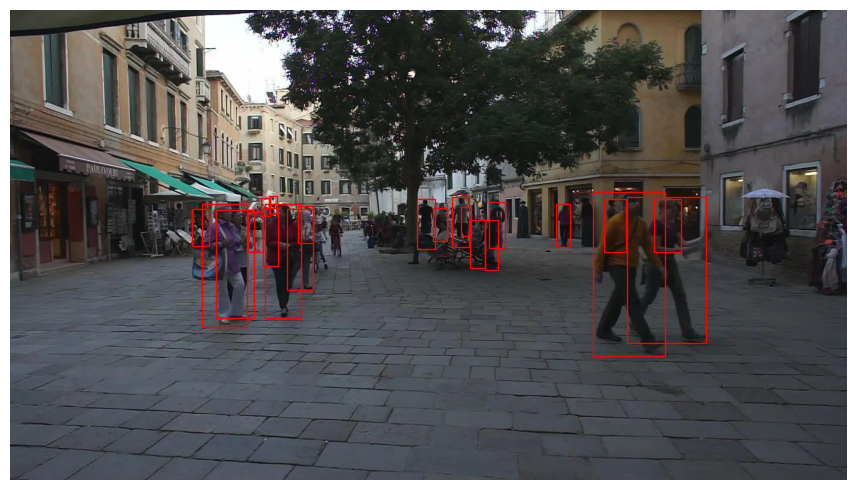

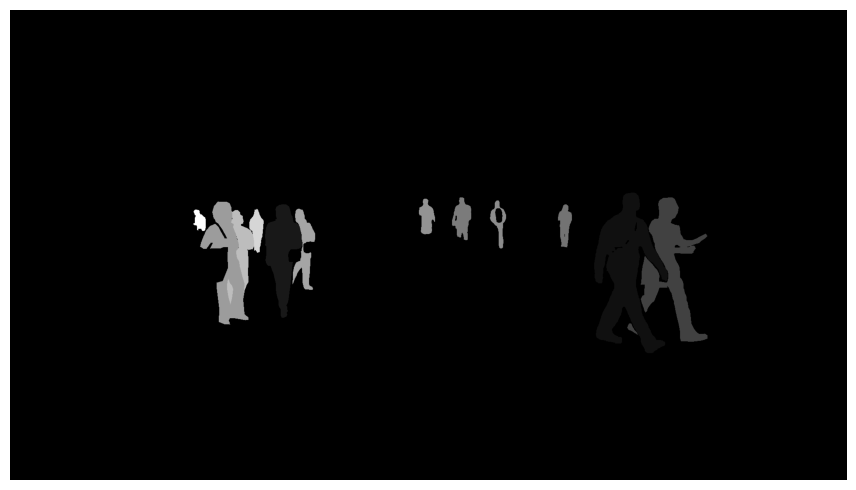

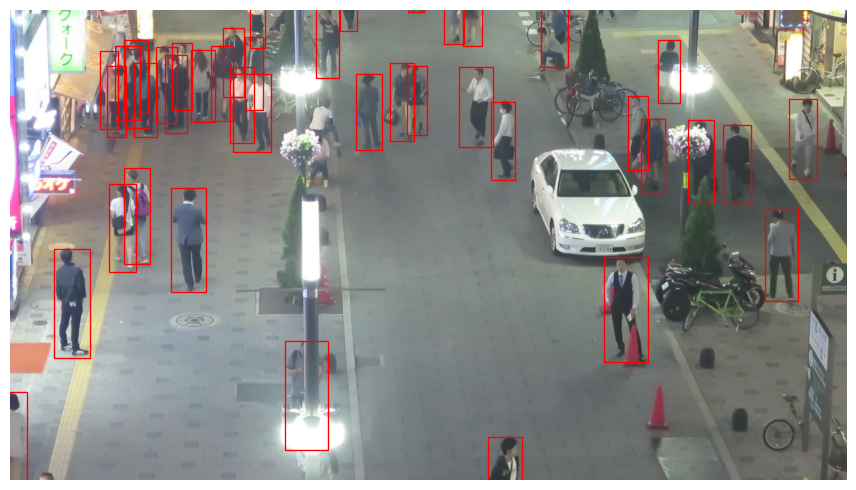

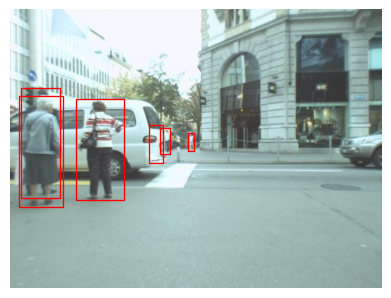

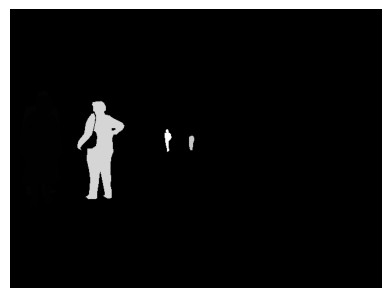

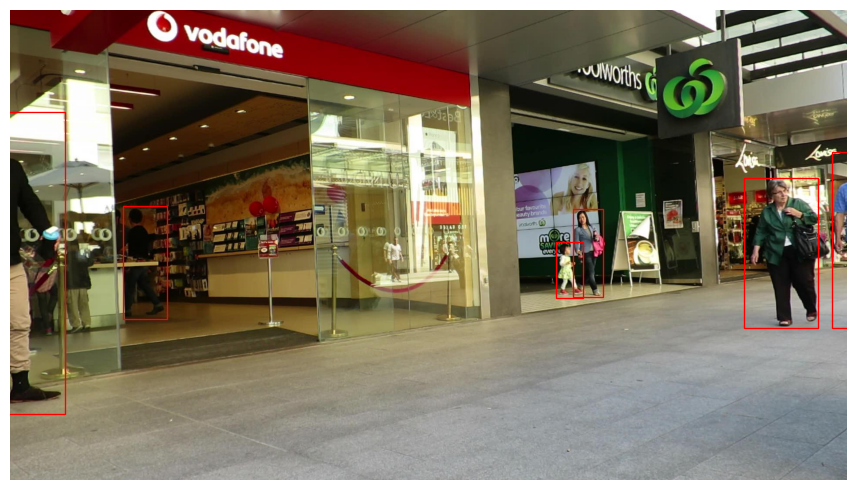

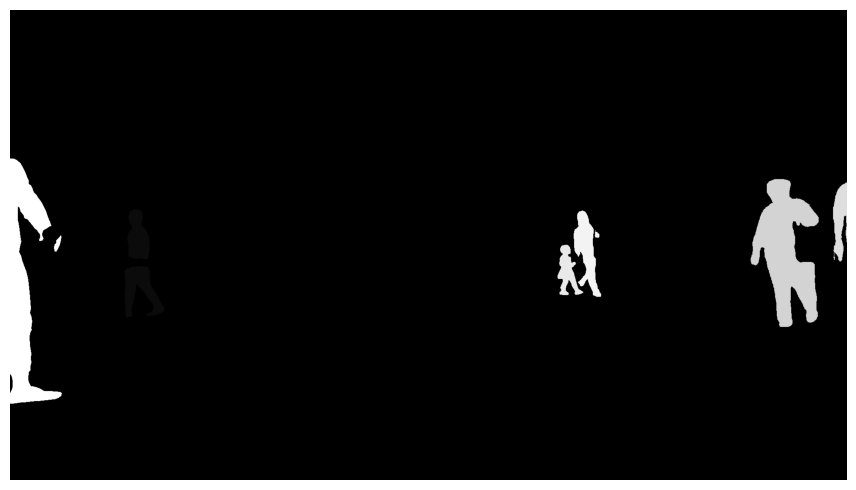

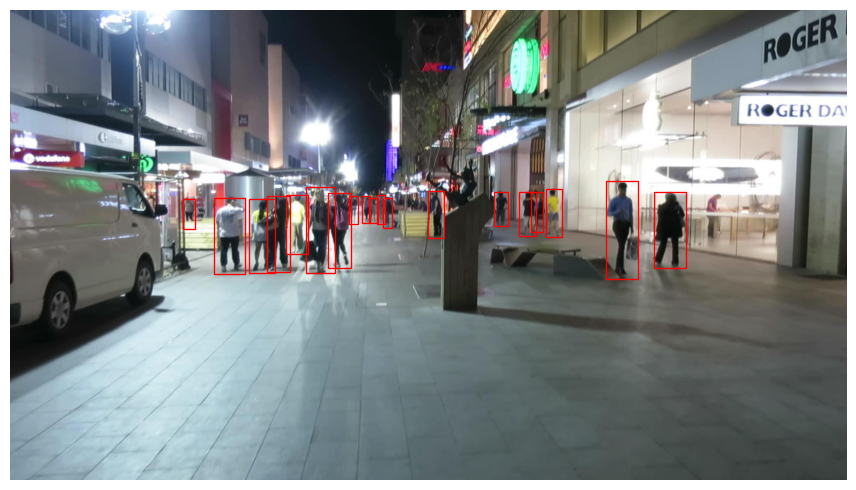

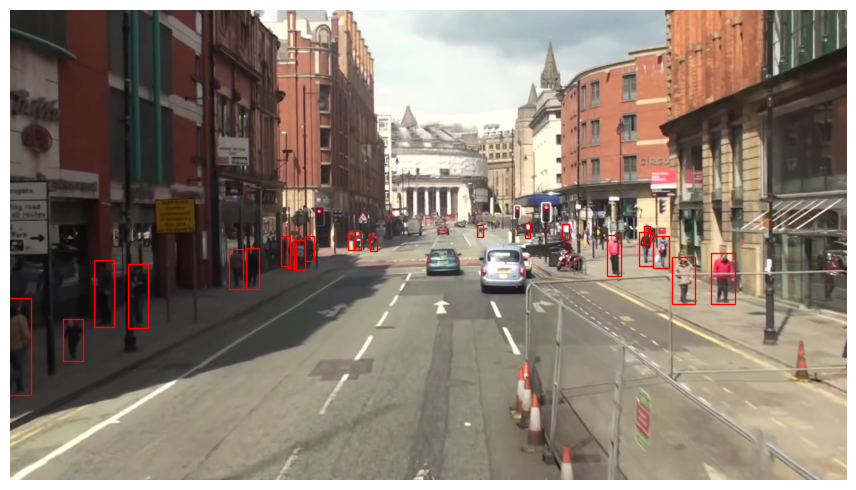

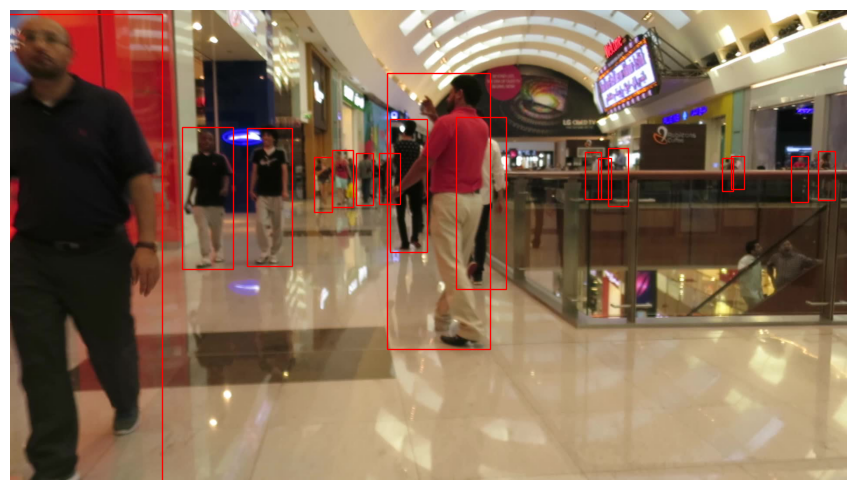

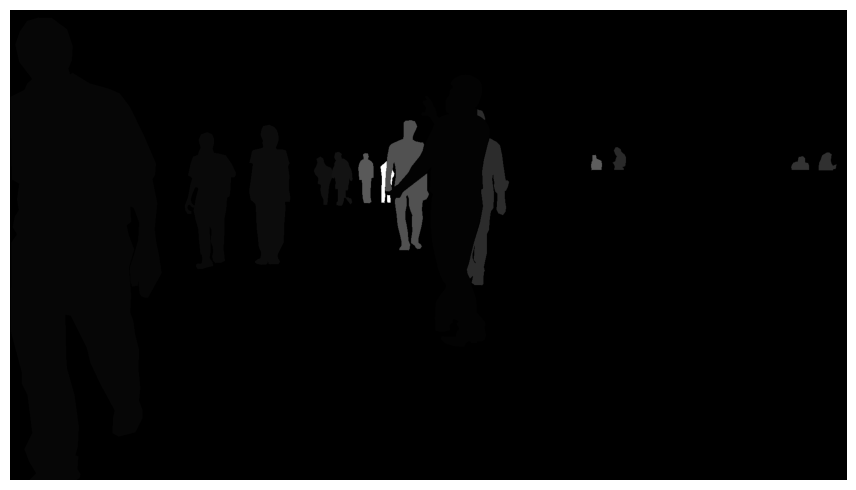

In [7]:
seq_name = 'MOT16-train'
# seq_name = 'MOT16-05'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  edgecolor="red",
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

In [8]:
print(len(sequences))
print(type(sequences))
for seq in sequences:
  print(type(seq))
  print(len(seq))
  for i, frame in enumerate(seq):
      print(frame.keys())
      print(frame['gt'].keys())
      print(frame['vis'].keys())
      # print(type(frame['seg_img']))
      break

7
<class 'tracker.data_track.MOT16Sequences'>
<class 'tracker.data_track.MOT16Sequence'>
600
dict_keys(['img', 'img_path', 'gt', 'vis', 'seg_img'])
dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
<class 'tracker.data_track.MOT16Sequence'>
1050
dict_keys(['img', 'img_path', 'gt', 'vis'])
dict_keys([1, 2, 3, 4, 5, 6, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 116])
dict_keys([1, 2, 3, 4, 5, 6, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 116])
<class 'tracker.data_track.MOT16Sequence'>
837
dict_keys(['img', 'img_path', 'gt', 'vis', 'seg_img'])
dict_keys([1, 2, 14, 117, 125, 150])
dict_keys([1, 2, 14, 117, 125, 150])
<class 'tracker.data_track.MOT16Sequence'>

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [9]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [10]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

cuda


FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequenti














































































If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:

`AP: 0.8677356206210984 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0`

data/MOT16/train:

`AP: 0.8667513486835257 Prec: 0.9220888904528979 Rec: 0.916776488424981 TP: 78609.0 FP: 6642.0`



In [12]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'), obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

evaluate_obj_detect(obj_detect, data_loader_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



AP: 0.8667513486835257 Prec: 0.9220888904528979 Rec: 0.916776488424981 TP: 78609.0 FP: 6642.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


min score: 0.9979598522186279


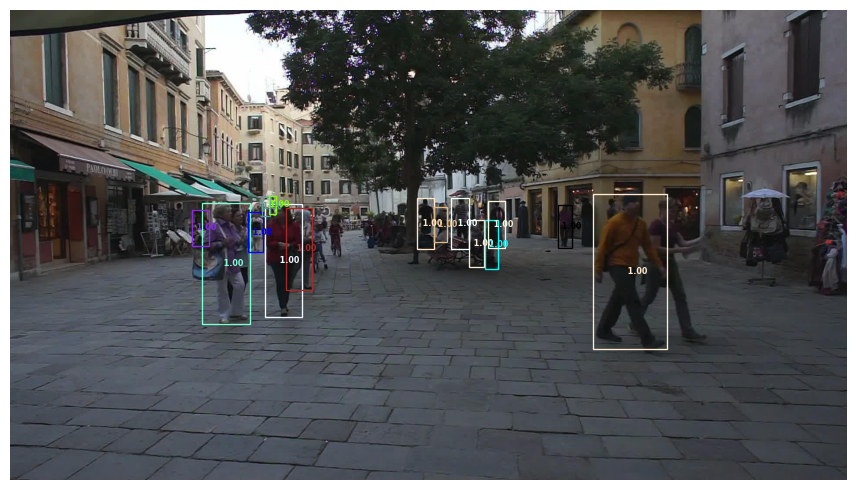

In [14]:
# visualize object detector

seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir)
results_seq = {}
tracker = Tracker(obj_detect)
for seq in sequences:
    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for i, frame in enumerate(data_loader):
        tracker.reset()
        tracker.step(frame)
        results = tracker.get_results()
        results_seq[str(seq)] = results
        print(f"min score: {np.min([results[i][0][4] for i in results.keys()])}")

        plot_sequence(results_seq['MOT16-02'],
              [[s for s in sequences if str(s) == 'MOT16-02'][0][i]])
        
        if i==0:
          break


# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [15]:
seed = 12345
seq_name = 'MOT16-train'
# seq_name = 'MOT16-09'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

## Setup

In [16]:
# original tracker
class TrackerIoUAssignment(Tracker):
    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
                    t.score = scores[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)        



In [20]:
# my advanced tracker
class TrackerIoUAssignmentAdvanced(Tracker):

    def __init__(self, obj_detect, sigma_iou, initialize_unmatched_detections, allow_frame_skips=0):
        super().__init__(obj_detect)
        self.sigma_iou = sigma_iou # inverse of sigma_iou in paper
        self.initialize_unmatched_detections = initialize_unmatched_detections
        self.allow_frame_skips = allow_frame_skips
        self.inactive_tracks = [] # list of track lists that were deactivated at each timestep

    def get_nonterminated_tracks(self):
        '''
        Returns a list of non-terminated (active + inactive) tracks.
        '''
        nonterminated_tracks = list(self.tracks) # active tracks
        for i in range(self.allow_frame_skips):
          if i < len(self.inactive_tracks):
            tracks_vanished_i_steps_ago = self.inactive_tracks[-(i+1)]
            nonterminated_tracks.extend(tracks_vanished_i_steps_ago)

        return nonterminated_tracks

    def reactivate_tracks(self, reactivated_tracks):
        '''
        Deletes the specified tracks from the inactive tracks.
        '''
        # self.print_inactive_tracks()
        
        for step in self.inactive_tracks:
          for t in reactivated_tracks:
            if t in step:
              step.remove(t)

        # print("reactivated tracks")
        # self.print_inactive_tracks()

    def print_inactive_tracks(self):
        '''
        Prints the number of inactive tracks.
        '''
        num = 0
        for step in self.inactive_tracks:
          num += len(step)

        print(f"inactive tracks: {num}")

    def data_association(self, boxes, scores):
        # print("\n\n")
        if self.tracks:
            nonterminated_tracks = self.get_nonterminated_tracks()
            active_track_ids = [t.id for t in self.tracks]
            # print(f"active tracks: {len(active_track_ids)}")
            # print(f"nonterminated_tracks: {len(nonterminated_tracks)}")
            track_ids = [t.id for t in nonterminated_tracks]
            track_boxes = np.stack([t.box.numpy() for t in nonterminated_tracks], axis=0)
            # print(f"track_boxes: {track_boxes.shape}")
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=self.sigma_iou) # n_tracks x n_detections matrix
            # print(f"distance: {distance.shape}")

            # update existing tracks
            remove_track_ids = [] # ids of active tracks that are deactivated in this step
            reactivate_track_ids = [] # ids of inactive tracks that are reactivated in this step
            # print(f"detections: {boxes.shape[0]}")
            not_matched_detection_ids = list(range(boxes.shape[0]))
            for t, dist in zip(nonterminated_tracks, distance):
                if np.isnan(dist[not_matched_detection_ids]).all():
                    if t.id in active_track_ids: 
                      remove_track_ids.append(t.id)
                      
                else:
                    match_id_within_not_matched = np.nanargmin(dist[not_matched_detection_ids])
                    match_id = not_matched_detection_ids[match_id_within_not_matched]
                    t.box = boxes[match_id]
                    t.score = scores[match_id]
                    not_matched_detection_ids.remove(match_id)  # makes sure every detection is only matched once
                    if t.id not in active_track_ids: 
                        # if an inactive track is matched
                        reactivate_track_ids.append(t.id)

            # deactivate tracks with no matched detection
            deactivated_tracks = [t for t in self.tracks if t.id in remove_track_ids]
            # print(f"deactivated tracks: {len(deactivated_tracks)}")
            self.inactive_tracks.append(deactivated_tracks)

            # terminate tracks that are inactive for too long
            # print(f"self.inactive_tracks: {len(self.inactive_tracks)}")
            if len(self.inactive_tracks) > self.allow_frame_skips:
              self.inactive_tracks.pop(0)      
            
            
            still_active_tracks = [t for t in self.tracks if t.id not in remove_track_ids]
            # print(f"still_active_tracks: {len(still_active_tracks)}")
            reactivated_tracks = [t for t in nonterminated_tracks if t.id in reactivate_track_ids]
            # print(f"reactivated tracks: {len(reactivated_tracks)}")
            self.reactivate_tracks(reactivated_tracks)
            self.tracks = still_active_tracks + reactivated_tracks

            if self.initialize_unmatched_detections:
              # add new tracks (add detections that are not matched)
              # print(f"new tracks: {len(not_matched_detection_ids)}")
              new_boxes = boxes[not_matched_detection_ids]
              new_scores = scores[not_matched_detection_ids]
              self.add(new_boxes, new_scores)
            else: 
              # add new tracks (add detections that are far away from tracks)
              new_boxes = []
              new_scores = []
              for i, dist in enumerate(np.transpose(distance)):
                  if np.isnan(dist).all():
                      new_boxes.append(boxes[i])
                      new_scores.append(scores[i])
              self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)

        # print(f"total tracks after step: {len(self.tracks)}")


## Run original tracker

In [19]:
tracker = TrackerIoUAssignment(obj_detect)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


KeyboardInterrupt: ignored


              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 32.2% 49.8% 23.8% 30.8% 64.3%  62   5  22  35  3172 12860  52   91 13.4% 0.087
    MOT16-04 54.2% 55.7% 52.8% 64.4% 68.0%  83  28  37  18 14441 16924  82  172 33.9% 0.109
    MOT16-05 48.1% 54.2% 43.2% 57.8% 72.5% 133  38  66  29  1515  2918  87  103 34.7% 0.144
    MOT16-09 43.0% 48.9% 38.4% 51.9% 66.2%  26   7  14   5  1412  2559  39   70 24.7% 0.107
    MOT16-10 35.3% 40.6% 31.3% 42.0% 54.5%  57  13  23  21  4492  7449  67  118  6.5% 0.138
    MOT16-13 47.0% 64.2% 37.0% 44.8% 77.6% 110  27  34  49  1502  6432  83  130 31.1% 0.135
    MOT16-11 49.4% 55.0% 44.8% 55.5% 68.2%  75  15  33  27  2447  4198  19   36 29.4% 0.080
    OVERALL  47.1% 53.6% 42.0% 52.5% 67.0% 546 133 229 184 28981 53340 429  720 26.3% 0.112

In [ ]:
t_id = 35
print(len(results[t_id].keys()))
np.max([results[t_id][frame][4] for frame in results[t_id]])

The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT17-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT17-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT17-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT17-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT17-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT17-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT17-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Run Grid Search for Advanced Tracker (without allow_skip_frames)

In [24]:
from itertools import product
from tracker.utils import save_evaluate_mot_accums
import copy

obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
                           

obj_detect_nms_thresh_list = [0.3]
sigma_iou_list = [0.5]
sigma_h_list = [0]
t_min_list = [1]
initialize_unmatched_detections_list = [True]
allow_frame_skips_list = [0]

for args in product(obj_detect_nms_thresh_list, sigma_iou_list, initialize_unmatched_detections_list): #, allow_frame_skips_list
  print(args)
  obj_detect_nms_thresh, sigma_iou, initialize_unmatched_detections = args #, allow_frame_skips

  output_file = os.path.join(root_dir, f'output/{args}{(sigma_h_list[-1], t_min_list[-1])}metrics.txt')
  if os.path.isfile(output_file):
    print(f"{output_file} already exists")
    # continue

  # object detector
  obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
  obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
  obj_detect.load_state_dict(obj_detect_state_dict)
  obj_detect.eval()
  obj_detect.to(device)

  # tracker
  tracker = TrackerIoUAssignmentAdvanced(obj_detect, sigma_iou, initialize_unmatched_detections) #, allow_frame_skips

  time_total = 0
  
  results_seq = {}
  for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results    

    time_total += time.time() - now

    # print(f"Tracks found: {len(results)}")
    # print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    # seq.write_results(results, os.path.join(output_dir_args))

    print(f"Runtime for all sequences: {time_total:.1f} s.")

  for result_selection_args in product(sigma_h_list, t_min_list):
    now = time.time()
    print(f"Selecting Tracks for Parameters: {args}{result_selection_args}")
    mot_accums = []
    sigma_h, t_min = result_selection_args

    output_file = os.path.join(root_dir, f'output/{args}{result_selection_args}metrics.txt')
    if os.path.isfile(output_file):
      print(f"{output_file} already exists")
      # continue

    for seq in sequences:
      results = results_seq[str(seq)]
      results_selected = copy.deepcopy(results)
      for t_id in results.keys():
        # print(f"Track {t_id}")
        track_length = len(results[t_id].keys())
        # print(f"track_length {track_length}")
        best_detection = np.max([results[t_id][frame][4] for frame in results[t_id]])
        # print(f"best_detection {best_detection}")
        if track_length < t_min or best_detection < sigma_h:
          results_selected.pop(t_id)

      if seq.no_gt:
        print(f"No GT evaluation data available.")
      else:
        mot_accums.append(get_mot_accum(results_selected, seq))

    if mot_accums:
      save_evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        output_file,
                        generate_overall=True)
      
    print(f"Runtime for subparameters: {time.time() - now:.1f} s.")
    

  
  


(0.3, 0.5, True)
gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/(0.3, 0.5, True)(0, 1)metrics.txt already exists
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Runtime for all sequences: 95.7 s.
Tracking: MOT16-04



Runtime for all sequences: 273.0 s.
Tracking: MOT16-05



Runtime for all sequences: 354.1 s.
Tracking: MOT16-09



Runtime for all sequences: 436.5 s.
Tracking: MOT16-10



Runtime for all sequences: 539.3 s.
Tracking: MOT16-13



Runtime for all sequences: 658.6 s.
Tracking: MOT16-11



Runtime for all sequences: 798.1 s.
Selecting Tracks for Parameters: (0.3, 0.5, True)(0, 1)
gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/(0.3, 0.5, True)(0, 1)metrics.txt already exists
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-02 34.3% 48.7% 26.5% 52.2% 96.1%  62  11  39 12  390  8873  398   224 48.0% 0.095
MOT16-04 58.4% 67.9% 51.2% 73.9% 97.9%  83  40  30 13  741 12434  266   288 71.7% 0.102
MOT16-05 49.6% 58.6% 43.0% 68.8% 94.0% 133  55  66 12  305  2156  254   156 60.7% 0.142
MOT16-09 37.1% 45.8% 31.1% 66.3% 97.7%  26   9  16  1   83  1794  123    96 62.4% 0.088
MOT16-10 41.8% 44.2% 39.6% 80.3% 89.5%  57  36  20  1 1205  2527  475   266 67.2% 0.151
MOT16-13 51.0% 51.9% 50.2% 85.4% 88.3% 110  85  21  4 1313  1694  537   193 69.6% 0.134
MOT16-11 56.2% 61.9% 51.4% 80.2% 96.6%  75  44  24  7  266  1871  141    90 75.9% 0.083
OVERALL  50.3% 58.3% 44.2% 72.1% 95.0% 546 280 216 50 4303 31349 2194  1313 66.3% 0.111
Runtime for

## Run Grid Search for Advanced Tracker (with allow_skip_frames)

In [25]:
from itertools import product
from tracker.utils import save_evaluate_mot_accums
import copy

obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
                           

obj_detect_nms_thresh_list = [0.4]
sigma_iou_list = [0.2]
sigma_h_list = [0.95]
t_min_list = [2]
initialize_unmatched_detections_list = [True]
allow_frame_skips_list = [0,1,2,3]

for args in product(obj_detect_nms_thresh_list, sigma_iou_list, initialize_unmatched_detections_list , allow_frame_skips_list): 
  print(args)
  obj_detect_nms_thresh, sigma_iou, initialize_unmatched_detections, allow_frame_skips = args 

  output_file = os.path.join(root_dir, f'output/{args}{(sigma_h_list[-1], t_min_list[-1])}metrics.txt')
  if os.path.isfile(output_file):
    print(f"{output_file} already exists")
    continue

  # object detector
  obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
  obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
  obj_detect.load_state_dict(obj_detect_state_dict)
  obj_detect.eval()
  obj_detect.to(device)

  # tracker
  tracker = TrackerIoUAssignmentAdvanced(obj_detect, sigma_iou, initialize_unmatched_detections, allow_frame_skips) 

  time_total = 0
  
  results_seq = {}
  for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results    

    time_total += time.time() - now

    # print(f"Tracks found: {len(results)}")
    # print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    # seq.write_results(results, os.path.join(output_dir_args))

    print(f"Runtime for all sequences: {time_total:.1f} s.")

  for result_selection_args in product(sigma_h_list, t_min_list):
    now = time.time()
    print(f"Selecting Tracks for Parameters: {args}{result_selection_args}")
    mot_accums = []
    sigma_h, t_min = result_selection_args

    output_file = os.path.join(root_dir, f'output/{args}{result_selection_args}metrics.txt')
    if os.path.isfile(output_file):
      print(f"{output_file} already exists")
      continue

    for seq in sequences:
      results = results_seq[str(seq)]
      results_selected = copy.deepcopy(results)
      for t_id in results.keys():
        # print(f"Track {t_id}")
        track_length = len(results[t_id].keys())
        # print(f"track_length {track_length}")
        best_detection = np.max([results[t_id][frame][4] for frame in results[t_id]])
        # print(f"best_detection {best_detection}")
        if track_length < t_min or best_detection < sigma_h:
          results_selected.pop(t_id)

      if seq.no_gt:
        print(f"No GT evaluation data available.")
      else:
        mot_accums.append(get_mot_accum(results_selected, seq))

    if mot_accums:
      save_evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        output_file,
                        generate_overall=True)
      
    print(f"Runtime for subparameters: {time.time() - now:.1f} s.")
    

  
  


(0.4, 0.2, True, 0)
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Runtime for all sequences: 95.7 s.
Tracking: MOT16-04



Runtime for all sequences: 272.8 s.
Tracking: MOT16-05



Runtime for all sequences: 353.1 s.
Tracking: MOT16-09



Runtime for all sequences: 435.1 s.
Tracking: MOT16-10



Runtime for all sequences: 537.4 s.
Tracking: MOT16-13



Runtime for all sequences: 657.0 s.
Tracking: MOT16-11



Runtime for all sequences: 796.9 s.
Selecting Tracks for Parameters: (0.4, 0.2, True, 0)(0.95, 2)
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs   FM  MOTA  MOTP
MOT16-02 39.2% 55.8% 30.2% 53.1% 98.1%  62  14  36 12  196  8717  193  134 51.0% 0.090
MOT16-04 70.4% 80.7% 62.5% 76.4% 98.5%  83  43  27 13  542 11241  114  135 75.0% 0.099
MOT16-05 55.1% 67.2% 46.7% 66.4% 95.5% 133  41  74 18  215  2327  204  132 60.3% 0.139
MOT16-09 50.3% 61.2% 42.7% 68.5% 98.2%  26  14  11  1   66  1677   69   52 66.0% 0.086
MOT16-10 46.7% 49.5% 44.1% 80.6% 90.5%  57  38  18  1 1086  2490  478  229 68.4% 0.150
MOT16-13 56.9% 59.2% 54.8% 83.6% 90.4% 110  73  32  5 1031  1908  480  194 70.6% 0.136
MOT16-11 67.3% 74.4% 61.4% 80.2% 97.3%  75  42  26  7  212  1868   73   45 77.2% 0.081
OVERALL  59.4% 68.7% 52.2% 73.1% 96.1% 546 265 224 57 3348 30228 1611  921 68.7% 0.109
Runtime for subparameters: 606.4 s.
(0.4, 0.2, True, 1)
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Runtime for all sequences: 95.6 s.
Tracking: MOT16-04



Runtime for all sequences: 273.3 s.
Tracking: MOT16-05



Runtime for all sequences: 353.6 s.
Tracking: MOT16-09



Runtime for all sequences: 436.2 s.
Tracking: MOT16-10



Runtime for all sequences: 539.8 s.
Tracking: MOT16-13



Runtime for all sequences: 660.3 s.
Tracking: MOT16-11



Runtime for all sequences: 800.8 s.
Selecting Tracks for Parameters: (0.4, 0.2, True, 1)(0.95, 2)
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-02 39.3% 55.6% 30.3% 53.3% 97.8%  62  14  36 12  227  8675  195   150 51.0% 0.090
MOT16-04 71.9% 82.2% 63.8% 76.5% 98.4%  83  43  27 13  578 11193   91   158 75.1% 0.100
MOT16-05 56.0% 68.0% 47.6% 66.8% 95.4% 133  43  72 18  223  2294  210   151 60.6% 0.140
MOT16-09 50.4% 61.3% 42.8% 68.6% 98.2%  26  14  11  1   66  1670   69    55 66.1% 0.087
MOT16-10 45.7% 47.9% 43.6% 81.0% 88.9%  57  38  18  1 1293  2433  515   233 67.0% 0.151
MOT16-13 56.2% 57.7% 54.7% 84.6% 89.3% 110  75  30  5 1177  1791  578   205 69.5% 0.137
MOT16-11 67.4% 74.3% 61.6% 80.5% 97.0%  75  42  27  6  231  1842   74    56 77.2% 0.082
OVERALL  59.8% 68.9% 52.9% 73.4% 95.6% 546 269 221 56 3795 29898 1732  1008 68.5% 0.110
Runtime for subparameters: 600.2 s.
(0.4, 0.2, True, 2)
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Runtime for all sequences: 96.4 s.
Tracking: MOT16-04



Runtime for all sequences: 276.0 s.
Tracking: MOT16-05



Runtime for all sequences: 357.3 s.
Tracking: MOT16-09



Runtime for all sequences: 440.7 s.
Tracking: MOT16-10



Runtime for all sequences: 545.2 s.
Tracking: MOT16-13



Runtime for all sequences: 666.6 s.
Tracking: MOT16-11



Runtime for all sequences: 808.2 s.
Selecting Tracks for Parameters: (0.4, 0.2, True, 2)(0.95, 2)
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-02 39.2% 55.5% 30.3% 53.4% 97.7%  62  14  36 12  238  8668  196   153 51.0% 0.090
MOT16-04 72.4% 82.6% 64.4% 76.6% 98.3%  83  43  27 13  627 11120   87   167 75.1% 0.101
MOT16-05 56.1% 68.0% 47.8% 66.9% 95.3% 133  44  71 18  230  2287  212   153 60.5% 0.140
MOT16-09 50.4% 61.3% 42.8% 68.7% 98.2%  26  14  11  1   66  1669   68    56 66.1% 0.087
MOT16-10 45.5% 47.5% 43.6% 81.2% 88.3%  57  38  18  1 1376  2412  528   235 66.4% 0.151
MOT16-13 56.3% 57.5% 55.2% 85.0% 88.6% 110  76  29  5 1272  1746  611   209 68.8% 0.138
MOT16-11 67.3% 74.1% 61.7% 80.7% 96.9%  75  43  26  6  242  1825   75    63 77.3% 0.082
OVERALL  60.0% 68.9% 53.2% 73.5% 95.3% 546 272 218 56 4051 29727 1777  1036 68.3% 0.110
Runtime for subparameters: 597.8 s.
(0.4, 0.2, True, 3)
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Runtime for all sequences: 96.1 s.
Tracking: MOT16-04



Runtime for all sequences: 275.5 s.
Tracking: MOT16-05



Runtime for all sequences: 357.0 s.
Tracking: MOT16-09



Runtime for all sequences: 440.2 s.
Tracking: MOT16-10



Runtime for all sequences: 544.8 s.
Tracking: MOT16-13



Runtime for all sequences: 666.2 s.
Tracking: MOT16-11



Runtime for all sequences: 806.7 s.
Selecting Tracks for Parameters: (0.4, 0.2, True, 3)(0.95, 2)
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-02 39.3% 55.6% 30.4% 53.4% 97.6%  62  14  36 12  242  8665  195   155 51.0% 0.090
MOT16-04 72.7% 82.9% 64.7% 76.7% 98.3%  83  43  27 13  633 11066   83   178 75.2% 0.101
MOT16-05 56.2% 67.9% 47.9% 67.1% 95.2% 133  44  71 18  233  2274  216   157 60.6% 0.140
MOT16-09 50.1% 60.9% 42.6% 68.7% 98.2%  26  14  11  1   66  1669   68    56 66.1% 0.087
MOT16-10 45.3% 47.2% 43.7% 81.3% 87.9%  57  38  18  1 1439  2396  540   230 65.9% 0.152
MOT16-13 56.0% 56.8% 55.2% 85.2% 87.7% 110  76  29  5 1391  1726  630   206 67.8% 0.138
MOT16-11 67.5% 74.3% 61.9% 80.7% 96.9%  75  43  26  6  246  1823   73    63 77.3% 0.082
OVERALL  60.1% 68.9% 53.3% 73.6% 95.1% 546 272 218 56 4250 29619 1805  1045 68.2% 0.110
Runtime for subparameters: 590.7 s.
(0.4, 0.2, True, 4)
Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


KeyboardInterrupt: ignored

## compare tracking results (without allow_skip_frames)

max_mota 68.7
max_idf 60.3
argmax_mota ['0.4,0.2,True,0.9,2', '0.4,0.2,True,0.95,2', '0.4,0.3,True,0.9,2', '0.4,0.3,True,0.9,3', '0.4,0.3,True,0.95,2', '0.4,0.3,True,0.99,1', '0.4,0.3,True,0.99,2', '0.4,0.3,True,0.99,3', '0.4,0.4,True,0.9,2', '0.4,0.4,True,0.9,3', '0.4,0.4,True,0.9,4', '0.4,0.4,True,0.95,2', '0.4,0.4,True,0.95,3']
argmax_idf ['0.45,0.2,True,0.99,4', '0.45,0.2,True,0.99,5']
idfs_with_max_mota ['59.3', '59.4', '58.3', '58.3', '58.3', '58.4', '58.5', '58.5', '55.8', '55.8', '55.9', '55.8', '55.8']
motas_with_max_idf [' 68.1', ' 68.1']


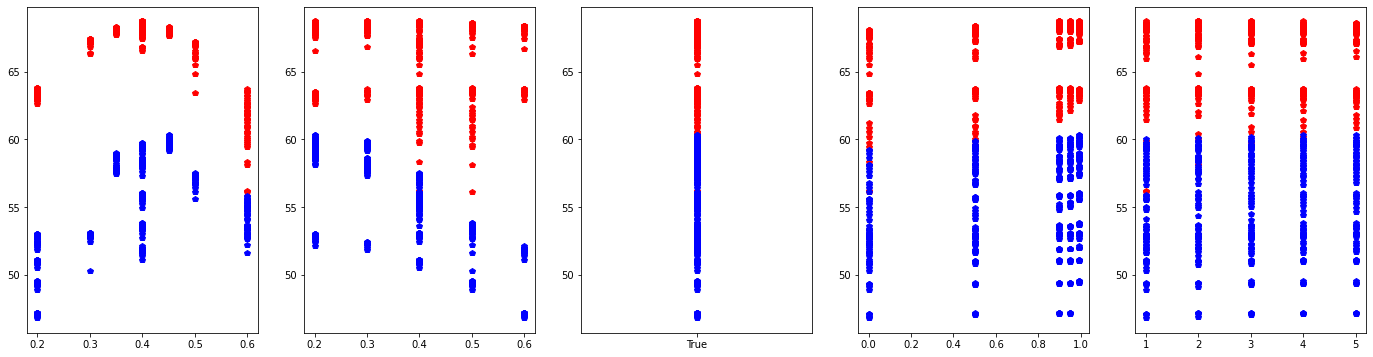

In [26]:
from itertools import product

obj_detect_nms_thresh_list = [0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
sigma_iou_list = [0.2, 0.3, 0.4, 0.5, 0.6]
sigma_h_list = [0, 0.5, 0.9, 0.95, 0.99]
t_min_list = [1,2,3,4,5]
initialize_unmatched_detections_list = [True]

motas = {}
idfs = {}

for args in product(obj_detect_nms_thresh_list, sigma_iou_list, initialize_unmatched_detections_list):
  for result_selection_args in product(sigma_h_list, t_min_list):
    arg1, arg2, arg3 = args
    arg4, arg5 = result_selection_args
    output_file = os.path.join(root_dir, f'output/{args}{result_selection_args}metrics.txt')
    if os.path.isfile(output_file):
      temp = open(output_file,'r').read().split('\n')
      # extract MOTA and IDF1 score from result summary
      motas[f"{arg1},{arg2},{arg3},{arg4},{arg5}"] = temp[-1][-12:-7]
      idfs[f"{arg1},{arg2},{arg3},{arg4},{arg5}"] = temp[-1][9:13]
      
max_mota = max([float(v) for v in motas.values()])
max_idf = max([float(v) for v in idfs.values()])
print(f"max_mota {max_mota}")
print(f"max_idf {max_idf}")

argmax_mota = [k for k,v in motas.items() if float(v) == max_mota]
argmax_idf = [k for k,v in idfs.items() if float(v) == max_idf]
print(f"argmax_mota {argmax_mota}")
print(f"argmax_idf {argmax_idf}")

idfs_with_max_mota = [idfs[k] for k in argmax_mota]
motas_with_max_idf = [motas[k] for k in argmax_idf]
print(f"idfs_with_max_mota {idfs_with_max_mota}")
print(f"motas_with_max_idf {motas_with_max_idf}")

x1, x2, x3, x4, x5, y1, y2 = [], [], [], [], [], [], []
for key in motas.keys():
  if key not in argmax_mota:
    # continue
    pass

  all_args = key.split(',')
  if float(all_args[0])!=0.45:
    # continue
    pass

  if float(all_args[1])!=0.4:
    # continue
    pass

  if all_args[2]=='True':
    # continue
    pass
  
  x1.append(float(all_args[0]))
  x2.append(float(all_args[1]))
  x3.append(all_args[2])
  x4.append(float(all_args[3]))
  x5.append(int(all_args[4]))
  y1.append(float(motas[key]))
  y2.append(float(idfs[key]))

plt.figure(1, figsize=(24, 6))
plt.subplot(151)
plt.plot(x1, y1, 'rp')
plt.plot(x1, y2, 'bp')
plt.subplot(152)
plt.plot(x2, y1, 'rp')
plt.plot(x2, y2, 'bp')
plt.subplot(153)
plt.plot(x3, y1, 'rp')
plt.plot(x3, y2, 'bp')
plt.subplot(154)
plt.plot(x4, y1, 'rp')
plt.plot(x4, y2, 'bp')
plt.subplot(155)
plt.plot(x5, y1, 'rp')
plt.plot(x5, y2, 'bp')


## generate results for best parameters (without allow_skip_frames)

best MOTA: 0.4, 0.2, True, 0.95, 2

best IDF1: 0.45, 0.2, True, 0.99, 5 (reached thresholds on test set)

In [27]:
obj_detect_nms_thresh = 0.4
sigma_iou = 0.2
initialize_unmatched_detections = True
sigma_h = 0.95
t_min = 2

obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

tracker = TrackerIoUAssignmentAdvanced(obj_detect, sigma_iou, initialize_unmatched_detections)

time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()

    keys = list(results.keys())
    for t_id in keys:
      # print(f"Track {t_id}")
      track_length = len(results[t_id].keys())
      # print(f"track_length {track_length}")
      best_detection = np.max([results[t_id][frame][4] for frame in results[t_id]])
      # print(f"best_detection {best_detection}")
      if track_length < t_min or best_detection < sigma_h:
        results.pop(t_id)

    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "



Tracks found: 146
Runtime for MOT16-02: 126.2 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-04



Tracks found: 174
Runtime for MOT16-04: 249.2 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-04.txt
Tracking: MOT16-05



Tracks found: 288
Runtime for MOT16-05: 88.2 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-05.txt
Tracking: MOT16-09



Tracks found: 76
Runtime for MOT16-09: 107.1 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-10



Tracks found: 255
Runtime for MOT16-10: 136.5 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-10.txt
Tracking: MOT16-13



Tracks found: 249
Runtime for MOT16-13: 158.0 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-13.txt
Tracking: MOT16-11



Tracks found: 113
Runtime for MOT16-11: 182.7 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-11.txt
Runtime for all sequences: 1048.0 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs   FM  MOTA  MOTP
MOT16-02 39.2% 55.8% 30.2% 53.1% 98.1%  62  14  36 12  196  8717  193  134 51.0% 0.090
MOT16-04 70.4% 80.7% 62.5% 76.4% 98.5%  83  43  27 13  542 11241  114  135 75.0% 0.099
MOT16-05 55.1% 67.2% 46.7% 66.4% 95.5% 133  41  74 18  215  2327  204  132 60.3% 0.139
MOT16-09 50.3% 61.2% 42.7% 68.5% 98.2%  26  14  11  1   66  1677   69   52 66.0% 0.086
MOT16-10 46.7% 49.5% 44.1% 80.6% 90.5%  57  38  18  1 1086  2490  478  229 68.4% 0.150
MOT16-13 56.9% 59.2% 54.8% 83.6% 90.4% 110  73  32  5 1031  1908  480  194 70.6% 0.136
MOT16-11 67.3% 74.4% 61.4% 80.2% 97.3%  75  42  26  7  212  1868   73   45 77.2% 0.081
OVERALL  59.4% 68.7% 52.2% 73.1% 96.1% 546 265 224 57 3348 30228 1611  921 68.7% 0.109


## merge Tracks in postprocessing that are close and with few skipped frames

In [28]:
import copy

max_frame_skips_list = [0,1,2,3,4,5]


for max_frame_skips in max_frame_skips_list:
  print(f"\n\n\n\n{max_frame_skips}\n")
  results_seq_merged = copy.deepcopy(results_seq)
  mot_accums = []

  for seq in sequences:
    print(f"{seq}")
    results = results_seq[str(seq)]
    results_selected = results_seq_merged[str(seq)]
    for t_id_1 in results.keys():
      t_ids_2 = []
      t1_max_frame = max(results[t_id_1].keys())

      for t_id_2 in results.keys():           
        t2_min_frame = min(results[t_id_2].keys())      
        if t1_max_frame < t2_min_frame and t1_max_frame >= t2_min_frame - max_frame_skips:
          t_ids_2.append(t_id_2)        
      

      if len(t_ids_2) > 0:
        # print(t_ids_2)

        t1_box = results[t_id_1][t1_max_frame][:-1]
        t2_boxes = np.empty((len(t_ids_2), 4))
        for i, t_id_2 in enumerate(t_ids_2):
          t2_min_frame = min(results[t_id_2].keys())
          t2_box = results[t_id_2][t2_min_frame][:-1]
          t2_boxes[i] = t2_box
        # print(f"t1_box {t1_box}")
        # print(f"t2_box {t2_boxes}")
          
        distance = mm.distances.iou_matrix(t1_box, t2_boxes, max_iou=0.5)
        dist = distance[0]
        # print(f"dist {dist}")

        if not np.isnan(dist).all():
          match_id_within_t2_boxes = np.nanargmin(dist)
          t_id_2 = t_ids_2[match_id_within_t2_boxes]
          t1_result = results[t_id_1]
          t2_result = results[t_id_2]


          # print(f"t_id_1 {t_id_1}")
          # print(f"t_id_2 {t_id_2}")
          # print(f"t1_max_frame {t1_max_frame}")
          # print(f"t2_min_frame {t2_min_frame}")
          # print(f"t1_box {t1_box}")
          # print(f"t2_box {t2_box}")
          
          # print(f"t1_result {t1_result.keys()}")
          # print(f"t2_result {t2_result.keys()}")
          results_selected[t_id_2].update(t1_result)
          del results_selected[t_id_1]
          # print(f"updated track: {results_selected[t_id_2].keys()}")

    print(f"tracks before merging: {len(results.keys())}")
    print(f"tracks after merging: {len(results_selected.keys())}")

    if seq.no_gt:
      print(f"No GT evaluation data available.")
    else:
      mot_accums.append(get_mot_accum(results_selected, seq))

  if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)






0

MOT16-02
tracks before merging: 146
tracks after merging: 146
MOT16-04
tracks before merging: 174
tracks after merging: 174
MOT16-05
tracks before merging: 288
tracks after merging: 288
MOT16-09
tracks before merging: 76
tracks after merging: 76
MOT16-10
tracks before merging: 255
tracks after merging: 255
MOT16-13
tracks before merging: 249
tracks after merging: 249
MOT16-11
tracks before merging: 113
tracks after merging: 113
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs   FM  MOTA  MOTP
MOT16-02 39.2% 55.8% 30.2% 53.1% 98.1%  62  14  36 12  196  8717  193  134 51.0% 0.090
MOT16-04 70.4% 80.7% 62.5% 76.4% 98.5%  83  43  27 13  542 11241  114  135 75.0% 0.099
MOT16-05 55.1% 67.2% 46.7% 66.4% 95.5% 133  41  74 18  215  2327  204  132 60.3% 0.139
MOT16-09 50.3% 61.2% 42.7% 68.5% 98.2%  26  14  11  1   66  1677   69   52 66.0% 0.086
MOT16-10 46.7% 49.5% 44.1% 80.6% 90.5%  57  38  18  1 1086  2490  478  229 68.4% 0.150
MOT16-13 56.9% 59.2% 54.8% 83.6% 90.4% 

## visualize results

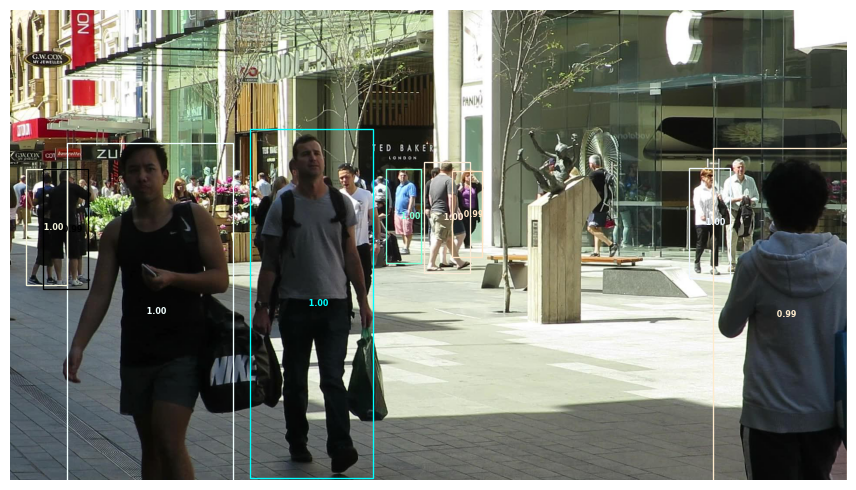

In [ ]:
plot_sequence(results_seq['MOT16-08'],
              [s for s in sequences if str(s) == 'MOT16-08'][0],
              first_n_frames=1)

In [ ]:
from cycler import cycler as cy
from collections import defaultdict
import glob
colors = [
    'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque',
    'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue',
    'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan',
    'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
    'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon',
    'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise',
    'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick',
    'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod',
    'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo',
    'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue',
    'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey',
    'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey',
    'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon',
    'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen',
    'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue',
    'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab',
    'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
    'palevioletred', 'papayawhip', 'peachpuff', 'peru', 'pink', 'plum', 'powderblue',
    'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon',
    'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
    'slategray', 'slategrey', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle',
    'tomato', 'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen'
]
def save_sequence(tracks, db, first_n_frames=None):
    """saves a whole sequence

    Args:
        tracks (dict): The dictionary containing the track dictionaries in the form tracks[track_id][frame] = bb
        db (torch.utils.data.Dataset): The dataset with the images belonging to the tracks (e.g. MOT_Sequence object)
    """

    # print("[*] Plotting whole sequence to {}".format(output_dir))

    # if not osp.exists(output_dir):
    # 	os.makedirs(output_dir)

    # infinite color loop
    cyl = cy('ec', colors)
    loop_cy_iter = cyl()
    styles = defaultdict(lambda: next(loop_cy_iter))

    os.mkdir("temp_images")

    for i, v in enumerate(db):
        img = v['img'].mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape

        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)
        fig.set_size_inches(width / dpi, height / dpi)
        ax.set_axis_off()
        ax.imshow(img)

        for j, t in tracks.items():
            if i in t.keys():
                t_i = t[i]
                ax.add_patch(
                    plt.Rectangle(
                        (t_i[0], t_i[1]),
                        t_i[2] - t_i[0],
                        t_i[3] - t_i[1],
                        fill=False,
                        linewidth=1.0, **styles[j]
                    ))

                ax.annotate(j, (t_i[0] + (t_i[2] - t_i[0]) / 2.0, t_i[1] + (t_i[3] - t_i[1]) / 2.0),
                            color=styles[j]['ec'], weight='bold', fontsize=6, ha='center', va='center')


        plt.axis('off')
        plt.tight_layout()
        # plt.show()
        plt.savefig("temp_images" + "/file%04d.png" % i, bbox_inches='tight')
        plt.close(fig)

        if first_n_frames is not None and first_n_frames - 1 == i:
            break

    
    os.chdir("temp_images")
    !ffmpeg -framerate 8 -i file%04d.png -r 30 video.mp4
    for file_name in glob.glob("*.png"):
      pass
      #os.remove(file_name)
    os.chdir("..")

KeyboardInterrupt: ignored

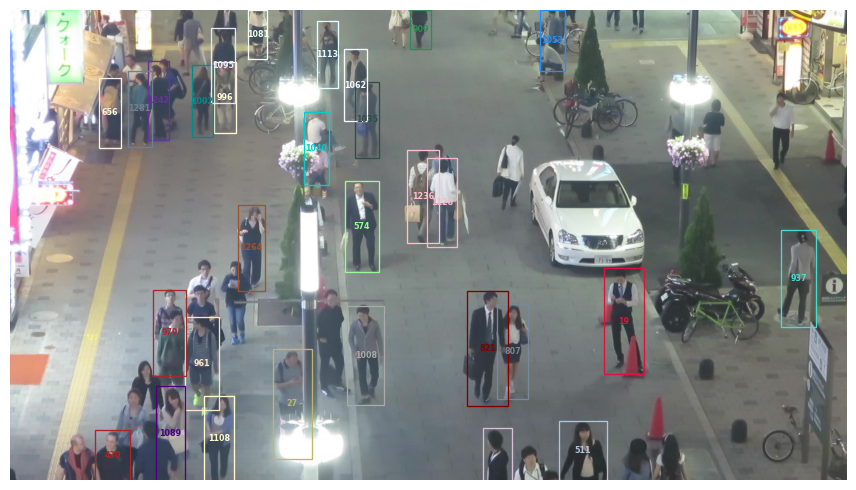

In [ ]:
!rm -r temp_images
save_sequence(results_seq['MOT16-03'],
              [s for s in sequences if str(s) == 'MOT16-03'][0],
              #first_n_frames=10
              )

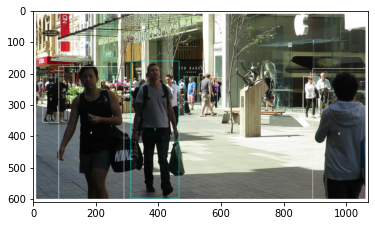

In [ ]:
img = plt.imread("temp_images/file0000.png")
plt.imshow(img)

In [29]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('temp_images/video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

FileNotFoundError: ignored

In [ ]:
from google.colab import files
files.download('temp_images/video.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.

We will make the test sequences and minimum `MOTA` for receiving the exam bonus available by the end of december.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"